In [ ]:
!pip install torchmetrics
!pip install pytorch_accelerated
!pip install torchviz
# !pip install ptflops
# !pip install fvcore
# !pip install torch-opcounter
!pip install --upgrade calflops
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
# from ptflops import get_model_complexity_info
# from fvcore.nn import FlopCountAnalysis
from calflops import calculate_flops
from thop import profile


from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

import pickle
import os
import shutil
from google.colab import drive

INFO:pytorch_accelerated:Setting random seeds


In [ ]:
# 1 load dataset from google drive
# mount google drive to the notebook
drive.mount('/content/drive')
# init the path for data and model in google drive
data_path_drive = "drive/MyDrive/tomato_leaf_disease/"
model_path_drive = "drive/MyDrive/tomato_pretrainedmodel2/"
result_path_drive = "drive/MyDrive/tomato_result/"

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!ls drive/MyDrive/tomato_leaf_disease/
!unzip /content/Archive.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: train/Tomato___Spider_mites Two-spotted_spider_mite/f4a12c44-b3a8-4419-b34e-ae6bdfa7d765___Com.G_SpM_FL 9521.jpg  
  inflating: __MACOSX/train/Tomato___Spider_mites Two-spotted_spider_mite/._f4a12c44-b3a8-4419-b34e-ae6bdfa7d765___Com.G_SpM_FL 9521.jpg  
  inflating: train/Tomato___Spider_mites Two-spotted_spider_mite/b0d67356-4a29-4265-b549-3dc32c654c27___Com.G_SpM_FL 9365.jpg  
  inflating: __MACOSX/train/Tomato___Spider_mites Two-spotted_spider_mite/._b0d67356-4a29-4265-b549-3dc32c654c27___Com.G_SpM_FL 9365.jpg  
  inflating: train/Tomato___Spider_mites Two-spotted_spider_mite/db678f0b-cd38-408c-9029-33296dcd568d___Com.G_SpM_FL 8522.jpg  
  inflating: __MACOSX/train/Tomato___Spider_mites Two-spotted_spider_mite/._db678f0b-cd38-408c-9029-33296dcd568d___Com.G_SpM_FL 8522.jpg  
  inflating: train/Tomato___Spider_mites Two-spotted_spider_mite/e23ee999-dff9-4f41-bb30-58711bd4103e___Com.G_SpM_FL 8980.jpg  
  inflating: __MACOSX/train/Tomato___Spider_

In [ ]:

def create_datasets(image_size, data_mean, data_std, train_path, val_path, label_parser):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std)

    train_dataset = timm.data.dataset.ImageDataset(train_path, transform=train_transforms, class_map=label_parser)
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms, class_map=label_parser)

    return train_dataset, eval_dataset


In [ ]:
class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        # self.train_loss_fn = kwargs['loss_func']
        self.num_updates = None
        if mixup_args.get("mixup_alpha", None) is None or mixup_args.get("mixup_alpha", None) == 0:
           self.mixup_fn = None
        else:
          self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.ema_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_loss_metric = torchmetrics.MeanMetric()
        self.val_loss_metric = torchmetrics.MeanMetric()
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9)
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        if self.mixup_fn is not None:
          mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        else:
          mixup_xb, mixup_yb = xb, yb


        # train_loss = super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        # print("xb:{}, yb:{}".format(xb.shape, yb.shape))
        train_loss = super().calculate_train_batch_loss((xb, yb))
        # train_loss = super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        # print("train_loss['loss']:{}, yb:{}".format(train_loss['loss'], yb.shape))
        self.train_loss_metric.update(train_loss['loss'])

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) ## clip gradiae for vgg

        return train_loss
        # return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)

            # val_loss = super().calculate_train_batch_loss((outputs, yb))
            # print("val_loss['loss']:{}".format(val_loss['loss']))
            # print('val_loss: {}, yb:{}'.format(val_loss, yb.shape))
            val_loss = self.eval_loss_fn(outputs, yb)
            # print('outputs: {}, yb:{}'.format(outputs.shape, yb.shape))
            self.val_loss_metric.update(val_loss)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric("ema_model_accuracy", self.ema_accuracy.compute().cpu())
        self.run_history.update_metric("train_loss_metric", self.train_loss_metric.compute().cpu())
        self.run_history.update_metric("val_loss_metric", self.val_loss_metric.compute().cpu())
        self.accuracy.reset()
        self.ema_accuracy.reset()
        self.train_loss_metric.reset()
        self.val_loss_metric.reset()


NameError: name 'Trainer' is not defined

In [ ]:
from logging import raiseExceptions


# funtionn to tunning hyper params
def tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name="resnet50d", \
                   pretrained=False, opt_name='lookahead_AdamW', loss_func="CE", drop_path_rate=0):
  #  fixed params
  image_size = (224, 224)
  batch_size = 32
  bce_target_thresh = 0.2
  output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'


  # data path
  data_path = "/content/"
  train_path = os.path.join(data_path, "train")
  val_path = os.path.join(data_path, "val")
  class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
  assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
  id_to_class = {id: cls_name for idx, cls_name in enumerate(class_names)}
  num_classes = len(class_names)
  print("num_classes: {}, len classes:{}".format(num_classes, len(class_names)))

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  # mixup_args = dict(
  #       mixup_alpha=mixup,
  #       cutmix_alpha=cutmix,
  #       label_smoothing=smoothing,
  #       num_classes=num_classes,
  # )

  # mixup_args = dict(
  #       label_smoothing=smoothing,
  #       num_classes=num_classes,)

  mixup_args = dict(
      num_classes=num_classes,)

  if drop_path_rate > 0.0:
    mixup_args['drop_path_rate'] = drop_path_rate
  if mixup>0.0:
    mixup_args['mixup_alpha'] = mixup
  if cutmix>0.0:
    mixup_args['cutmix_alpha'] = cutmix

  # Create model using timm
  if drop_path_rate > 0.0:
      model = timm.create_model(
              model_name, pretrained=pretrained, num_classes=num_classes, drop_path_rate=drop_path_rate)
  else:
      model = timm.create_model(
              model_name, pretrained=pretrained, num_classes=num_classes)
  # model = timm.create_model(
  #     model_name, pretrained=pretrained, num_classes=num_classes, drop_path_rate=0.05
  # )
  model = model.to(device)

  # Load data config associated with the model to use in data augmentation pipeline
  data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
  data_mean = data_config["mean"]
  data_std = data_config["std"]

  # Create training and validation datasets
  train_dataset, eval_dataset = create_datasets(
      train_path=train_path,
      val_path=val_path,
      image_size=image_size,
      data_mean=data_mean,
      data_std=data_std,
      label_parser=class_to_idx,
  )

  # Create optimizer
  optimizer = timm.optim.create_optimizer_v2(
      model, opt=opt_name, lr=lr, weight_decay=0.01
  )

  # As we are using Mixup, we can use BCE during training and CE for evaluation
  # train_loss_fn = timm.loss.BinaryCrossEntropy(
  #     target_threshold=bce_target_thresh, smoothing=smoothing
  # )
  if loss_func=="CE":
    train_loss_fn = torch.nn.CrossEntropyLoss()
    validate_loss_fn = torch.nn.CrossEntropyLoss()
  elif loss_func=="LSCE":
    train_loss_fn = timm.loss.LabelSmoothingCrossEntropy(smoothing=smoothing)
    validate_loss_fn = timm.loss.LabelSmoothingCrossEntropy(smoothing=smoothing)
  else:
    raiseExceptions("Loss not supported!!!!!!!!!!")



  # Create trainer and start training
  trainer = TimmMixupTrainer(
      model=model,
      optimizer=optimizer,
      loss_func=train_loss_fn,
      eval_loss_fn=validate_loss_fn,
      mixup_args=mixup_args,
      num_classes=num_classes,
      callbacks=[
          *DEFAULT_CALLBACKS,
          SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
      ],
  )

  if not os.path.exists(f'/content/{output_name}.pth') and not os.path.exists(f'{model_path_drive}{output_name}.pth'):
    trainer.train(
        per_device_batch_size=batch_size,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        num_epochs=num_epochs,
        create_scheduler_fn=trainer.create_scheduler,
    )

    torch.save(model.state_dict(), f'{output_name}.pth')

    def save_history(trainer, output_name):
      history = {}
      for key in trainer.run_history.get_metric_names():
        history[key] = trainer.run_history.get_metric_values(key)

      with open(f'/content/{output_name}_run_history.pkl', 'wb') as f:
        pickle.dump(history, f)


    save_history(trainer, output_name)
  else:
    print(f'/content/{output_name}_run_history.pkl exists!!')

  output_path = os.path.join(model_path_drive, f'{output_name}_run_history.pkl')
  if not os.path.exists(output_path):
    shutil.copy(f'/content/{output_name}_run_history.pkl', model_path_drive)
  else:
    print(f'/content/{output_name}_run_history.pkl exists!!')

  output_path = os.path.join(model_path_drive, f'{output_name}.pth')
  if not os.path.exists(output_path):
    shutil.copy(f'/content/{output_name}.pth', model_path_drive)
  else:
    print(f'/content/{output_name}.pth exists!!')




In [ ]:
import matplotlib.pyplot as plt

def train_val_loss_plot(run_history_name, desc_string=""):
  with open(os.path.join(model_path_drive, run_history_name), 'rb') as f:
      loaded_history = pickle.load(f)
  # Plotting train and validation loss
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  print(loaded_history.keys())
  print(loaded_history['train_loss_metric'])
  print(loaded_history['eval_loss_epoch'])

  model_name = run_history_name.split("_")[0]
  plt.plot(loaded_history['train_loss_metric'], label="Train Loss")
  plt.plot(loaded_history['eval_loss_epoch'], label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"{model_name}-{desc_string}:Train and Validation Loss")
  plt.legend()
  plt.tight_layout()
  plt.show()

  # Plotting train and validation accuracy
  plt.subplot(1, 1, 1)
  plt.plot(loaded_history['accuracy'], label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title(f"{model_name}: Train and Validation Accuracy")
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
import torchmetrics
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from torchviz import make_dot
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

def create_eval_datasets(image_size, data_mean, data_std, val_path, label_parser):
    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms, class_map=label_parser)

    return eval_dataset

# Define a function to calculate and print all the metrics
def evaluate_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')  # F1 score
    recall = recall_score(y_test, y_pred, average='macro')  # Recall
    precision = precision_score(y_test, y_pred, average='macro')  # Precision
    accuracy = accuracy_score(y_test, y_pred)  # Accuracy
    return cm, f1, recall, precision, accuracy

# Define a function to calculate and print all the metrics
def evaluate_modelv2(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 score
    recall = recall_score(y_test, y_pred, average='weighted')  # Recall
    precision = precision_score(y_test, y_pred, average='weighted')  # Precision
    accuracy = accuracy_score(y_test, y_pred)  # Accuracy
    return cm, f1, recall, precision, accuracy


def plot_roc2(y_test, y_pred, num_classes, model_name, desc=""):
    plt.figure(figsize=(10, 8))

    encoder = OneHotEncoder(sparse_output=False)
    if y_test.ndim == 1 or y_test.shape[1] == 1:
        one_hot_y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
    else:
        one_hot_y_test = y_test

    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        one_hot_y_pred = encoder.transform(np.array(y_pred).reshape(-1, 1))
    else:
        one_hot_y_pred = y_pred

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(one_hot_y_test[:, i], one_hot_y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}-{desc}")
    plt.legend(loc="lower right")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#  dataset init
train_path = os.path.join(data_path_drive, "train")
val_path = os.path.join(data_path_drive, "val")
class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
id_to_class = {idx: cls_name.split("Tomato___")[-1] for idx, cls_name in enumerate(class_names)}
num_classes = len(class_names)

In [ ]:
#  eval function
def model_infer(model_name, load_weight_name, is_summary=False, is_vis=False, is_plot_roc=False):
  model_eval = timm.create_model(
      model_name, pretrained=True, num_classes=10)

  model_eval = model_eval.to(device)

  model_eval.load_state_dict(torch.load(os.path.join(model_path_drive, load_weight_name), map_location=device))
  model_eval.eval()

  if is_summary:
    summary(model_eval, input_size=(3, 224, 224))
    vis_model(model_eval)


  # creat data config
  data_config = timm.data.resolve_data_config({}, model=model_eval, verbose=True)
  data_mean = data_config["mean"]
  data_std = data_config["std"]
  image_size = (224, 224)
  # Create training and validation datasets
  eval_dataset = create_eval_datasets(
      val_path=val_path,
      image_size=image_size,
      data_mean=data_mean,
      data_std=data_std,
      label_parser=class_to_idx,)

  print("!!!!num_classes: {}, len classes:{}".format(num_classes, len(class_names)))
  if is_vis:
    diplay_pic_num = 5
    pic_sample_freq = 2
    show_id = 0
    fig, axes = plt.subplots(1, diplay_pic_num, figsize=(15, 5))
    plt.ion()

  accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

  y_labels = []
  pre_labels = []
  pred_probs = []
  with torch.no_grad():
      # for idx, cur_eval_data in enumerate(eval_dataset):
      for idx, cur_eval_data in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
          # print("image: {}, label :{}".format(images.size(), labels))
          images, labels_orig = cur_eval_data
          label_classname = eval_dataset.filenames()[idx].split("/")[0].split("Tomato___")[-1]
          labels = torch.tensor(labels_orig).to(device)
          images, labels = images.to(device), torch.tensor(labels).to(device)
          images = images.unsqueeze(0)

          outputs = model_eval(images)
          labels = labels.to(torch.int64).reshape(1)

          accuracy_metric.update(outputs.argmax(-1), labels)
          y_labels.append(labels.cpu().item())
          pre_labels.append(outputs.argmax(-1).cpu().item())
          pred_prob = outputs.squeeze().cpu().numpy()
          # print(pred_prob)
          pred_probs.append(pred_prob)

          ###### visual sample data
          if is_vis:
            if idx%pic_sample_freq == 0 and show_id<diplay_pic_num:
              image_tmp = Image.open(os.path.join(val_path, eval_dataset.filenames()[idx]))
              axes[show_id].imshow(image_tmp)
              axes[show_id].set_title(f"Pred: {id_to_class[outputs.argmax(-1).cpu()[0].item()]}")
              axes[show_id].axis('off')
              show_id += 1
            if show_id == diplay_pic_num:
              plt.show()
          ##### print("label id:{}, label name: {}, id_map:{}, pred:{}".format(labels_orig, label_classname, id_to_class[labels_orig], outputs.argmax(-1).cpu()[0]))
  return y_labels, pre_labels, pred_probs, accuracy_metric




In [ ]:
def eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name="resnet50d", \
                   pretrained=False, opt_name='lookahead_AdamW', loss_func="CE", drop_path_rate=0, desc=""):
  #  run model evaluation
  load_weight_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}.pth'
  evaYLabel = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}_YLabel.npy'
  evaPreLabel = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}_PreLabel.npy'
  evaPreProb = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}_PreProb.npy'
  if not os.path.exists(os.path.join(result_path_drive, evaYLabel)):
    y_labels, pre_labels, pred_probs, accuracy_metric = model_infer(model_name, load_weight_name, is_summary=False, is_vis=False, is_plot_roc=True)

    #  save result to google drive
    with open(os.path.join(result_path_drive, evaYLabel), 'wb') as f:
      np.save(f, np.array(y_labels))
    with open(os.path.join(result_path_drive, evaPreLabel), 'wb') as f:
      np.save(f, np.array(pre_labels))
    with open(os.path.join(result_path_drive, evaPreProb), 'wb') as f:
      np.save(f, np.array(pred_probs))
  else:
    with open(os.path.join(result_path_drive, evaYLabel), 'rb') as f:
      y_labels = np.load(f)
    with open(os.path.join(result_path_drive, evaPreLabel), 'rb') as f:
      pre_labels = np.load(f)
    with open(os.path.join(result_path_drive, evaPreProb), 'rb') as f:
      pred_probs = np.load(f)



  model_eval = timm.create_model(model_name, pretrained=True, num_classes=10)
  model_eval.eval()
  print("*****************888888888888888*****************")
  input_shape = (1, 3, 224, 224)
  flops, macs, params = calculate_flops(model=model_eval,
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
  print("FLOPs:%s   MACs:%s\n" %(flops, macs))

  # input_tensor = (torch.rand(1, 3, 224, 224),)
  # flops, params = profile(model_eval, inputs=input_tensor)
  # print('FLOPs =', flops/1e9)
  # print('params =', params/1e6)


  #### evaluation
  print(f"************************Evaluation result of {model_name}:******************")
  # print(f"pre_labels.shape:{pre_labels.shape}")
  # print(f"pre_labels.ndim:{pre_labels.ndim}")
  cm, f1, recall, precision, accuracy = evaluate_modelv2(y_labels, pre_labels)
  plot_roc2(np.array(y_labels), np.array(pred_probs), 10, model_name, desc=desc)
  print("Confusion Matrix:\n", cm)
  print(f"F1 Score: {f1:.32f}")
  print(f"Recall: {recall:.32f}")
  print(f"Precision: {precision:.32f}")
  print(f"Accuracy: {accuracy:.32f}")
  return cm, f1, recall, precision, accuracy,flops, macs


In [ ]:
model_name_list = ['resnet50d', 'swin_s3_tiny_224', 'swin_s3_base_224', 'vgg16', 'vgg19', 'densenet121']
Flops_dic = {}
Accuracy_dic = {}
Params_dic = {}
F1_dic = {}
Fecall_dic = {}
Precision_dic = {}

num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50.pth exists!!
dict_keys(['eval_loss_epoch', 'accuracy', 'val_loss_metric', 'train_loss_metric', 'train_loss_epoch', 'ema_model_accuracy'])
[tensor(1.7333), tensor(1.4911), tensor(1.4044), tensor(1.3322), tensor(1.2836), tensor(1.2310), tensor(1.2017), tensor(1.1366), tensor(1.1281), tensor(1.0831), tensor(1.0408), tensor(1.0122), tensor(1.0002), tensor(0.9877), tensor(0.9645), tensor(0.9513), tensor(0.9142), tensor(0.8989), tensor(0.8814), tensor(0.8686), tensor(0.8602), tensor(0.8525), tensor(0.8362), tensor(0.8254), tensor(0.7971), tensor(0.7959), tensor(0.7937), tensor(0.7713), tensor(0.7691), tensor(0.7623), tensor(0.7269), tensor(0.7505), tensor(0.7461), tensor(0.7329), tensor(0.7248), tensor(0.7084), tensor(0

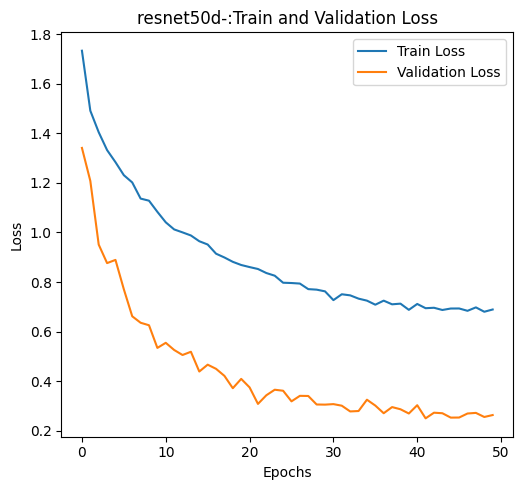

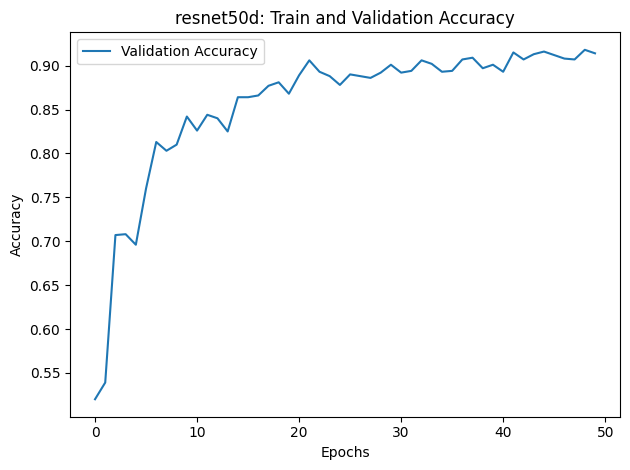

!!!!num_classes: 10, len classes:10


Evaluating:   0%|          | 0/1010 [00:00<?, ?it/s]<ipython-input-20-da235e7ae23f>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)
Evaluating: 100%|██████████| 1010/1010 [07:19<00:00,  2.30it/s]


*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

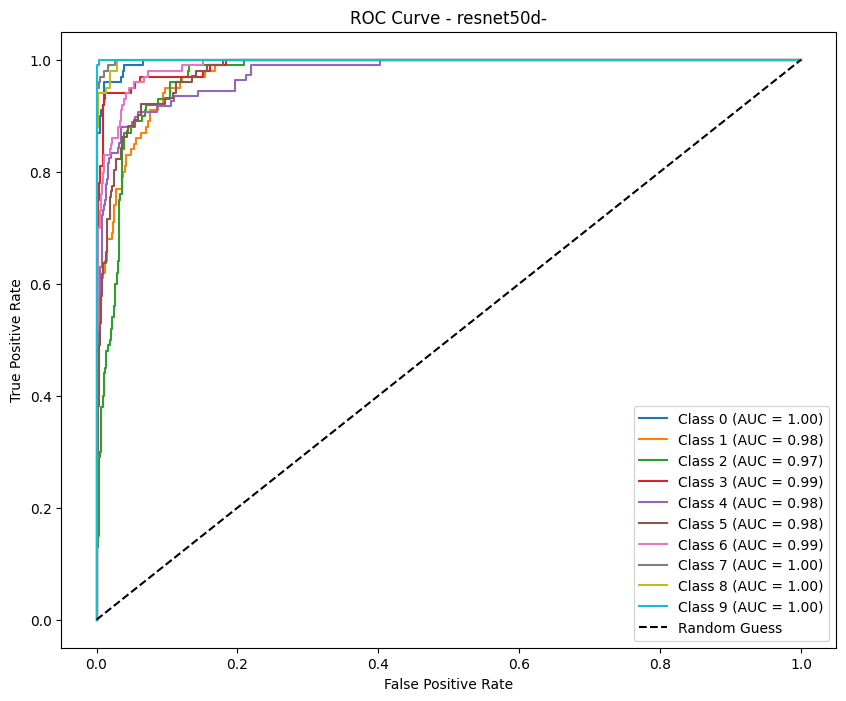

Confusion Matrix:
 [[ 97   1   0   0   0   0   2   0   0   0]
 [  1  85   7   0   2   0   5   0   0   0]
 [  3   1  92   1   2   0   0   0   0   1]
 [  0   1   3  95   0   0   0   0   1   0]
 [  4   3   5   0  91   0   1   0   1   3]
 [  0   0   0   0   0  86   7   0   3   6]
 [  0   0   0   0   2   4  92   0   0   2]
 [  4   0   0   1   0   2   0  93   0   0]
 [  0   0   0   0   0   0   6   0  94   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.91589081781877146326564798073377
Recall: 0.91584158415841587785877209171304
Precision: 0.91944101385183185648486414720537
Accuracy: 0.91584158415841587785877209171304


In [ ]:
######################## Train model selection: resnet50d ########################
lr = 5e-5                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

Flops_dic[model_name] = flops
Accuracy_dic[model_name] = accuracy
Params_dic[model_name] = macs
F1_dic[model_name] = f1
Fecall_dic[model_name] = recall
Precision_dic[model_name] = precision


num_classes: 10, len classes:10
/content/swin_s3_tiny_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/swin_s3_tiny_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/swin_s3_tiny_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50.pth exists!!
dict_keys(['eval_loss_epoch', 'accuracy', 'val_loss_metric', 'train_loss_metric', 'train_loss_epoch', 'ema_model_accuracy'])
[tensor(1.9760), tensor(1.4716), tensor(1.2762), tensor(1.1254), tensor(1.0287), tensor(0.9520), tensor(0.9013), tensor(0.8515), tensor(0.8019), tensor(0.7633), tensor(0.7380), tensor(0.7168), tensor(0.6793), tensor(0.6668), tensor(0.6225), tensor(0.6321), tensor(0.5935), tensor(0.5786), tensor(0.5688), tensor(0.5512), tensor(0.5461), tensor(0.5417), tensor(0.5164), tensor(0.5194), tensor(0.4773), tensor(0.4901), tensor(0.4749), tensor(0.4658), tensor(0.4451), tensor(0.4502), tensor(0.4191), tensor(0.4320), tensor(0.4282), tensor(0.4164), tensor(0.4152), ten

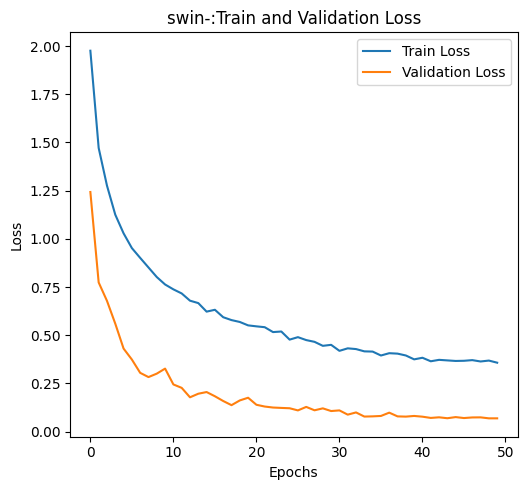

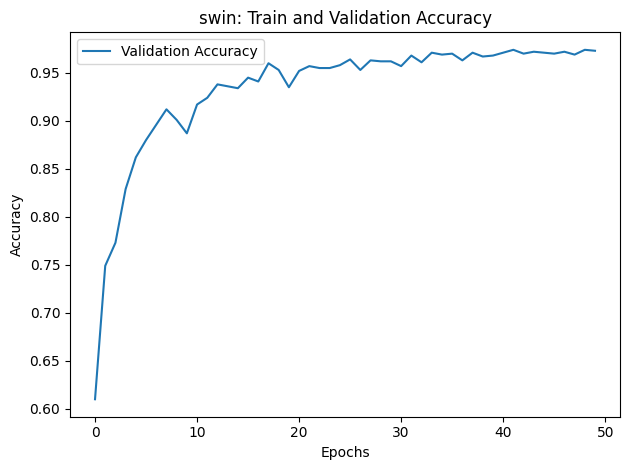

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  27.57 M 
fwd MACs:                                                               4.3497 GMACs
fwd FLOPs:                                                              8.7282 GFLOPS
fwd+bwd MACs:                                                           13.049 GMACs
fwd+bwd FLOPs:                                                          26.1847 GFLOPS

-------------------------------- Detailed Calculated FLOPs R

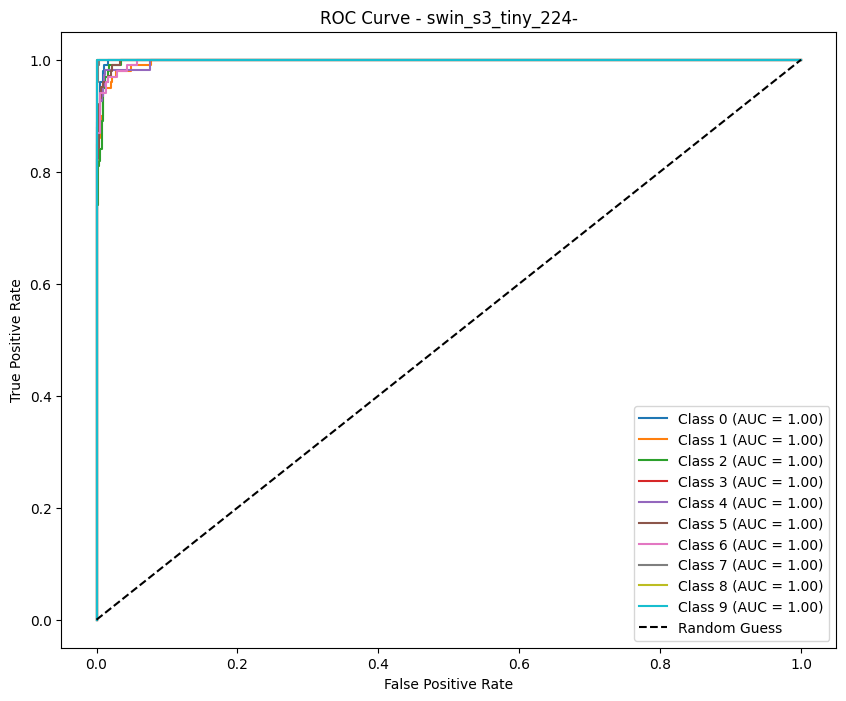

Confusion Matrix:
 [[ 98   0   0   0   1   0   0   1   0   0]
 [  0  94   3   0   0   1   2   0   0   0]
 [  0   2  97   0   1   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  3   0   1   0 104   0   0   0   0   0]
 [  0   0   0   0   0 101   0   0   0   1]
 [  0   0   0   0   1   6  92   0   0   1]
 [  2   0   0   0   0   0   0  98   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.97426989078358017248859823666862
Recall: 0.97431590413943358619519585772650
Precision: 0.97471813699749065840194361953763
Accuracy: 0.97425742574257423456174365128390


In [ ]:
######################## Train model selection: Transformer ########################
lr = 5e-5                                             ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1                                       ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                                           ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0                                          ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1                                      ## default 50
model_name="swin_s3_tiny_224"                         ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224/‎swin_s3_base_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False                                      ## True / False, defalt False
opt_name='lookahead_AdamW'                            ## defalt 'lookahead_AdamW', fixed
loss_func="CE"                                        ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

Flops_dic[model_name] = flops
Accuracy_dic[model_name] = accuracy
Params_dic[model_name] = macs
F1_dic[model_name] = f1
Fecall_dic[model_name] = recall
Precision_dic[model_name] = precision


num_classes: 10, len classes:10
/content/swin_s3_base_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/swin_s3_base_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/swin_s3_base_224_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50.pth exists!!
dict_keys(['train_loss_epoch', 'train_loss_metric', 'val_loss_metric', 'accuracy', 'ema_model_accuracy', 'eval_loss_epoch'])
[tensor(2.0533), tensor(1.5676), tensor(1.3652), tensor(1.1944), tensor(1.0726), tensor(0.9928), tensor(0.9216), tensor(0.8592), tensor(0.8176), tensor(0.7625), tensor(0.7421), tensor(0.7215), tensor(0.6665), tensor(0.6707), tensor(0.6267), tensor(0.6221), tensor(0.5969), tensor(0.5783), tensor(0.5538), tensor(0.5366), tensor(0.5300), tensor(0.5301), tensor(0.4983), tensor(0.5000), tensor(0.4662), tensor(0.4678), tensor(0.4618), tensor(0.4462), tensor(0.4300), tensor(0.4355), tensor(0.3984), tensor(0.4125), tensor(0.3976), tensor(0.3990), tensor(0.3906), ten

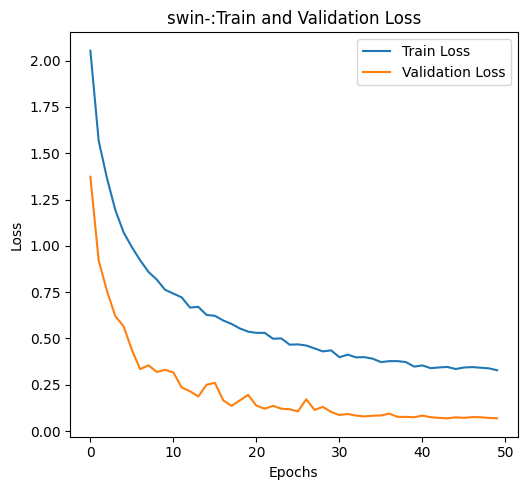

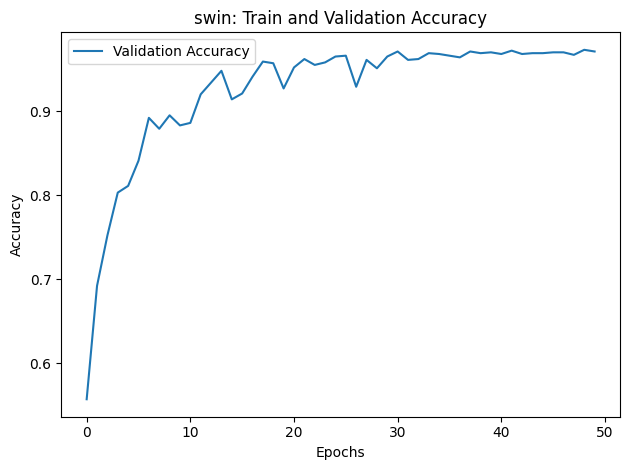

model.safetensors:   0%|          | 0.00/295M [00:00<?, ?B/s]

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  70.36 M 
fwd MACs:                                                               12.6733 GMACs
fwd FLOPs:                                                              25.4118 GFLOPS
fwd+bwd MACs:                                                           38.0198 GMACs
fwd+bwd FLOPs:                                                          76.2354 GFLOPS

-------------------------------- Detailed Calculated FLOP

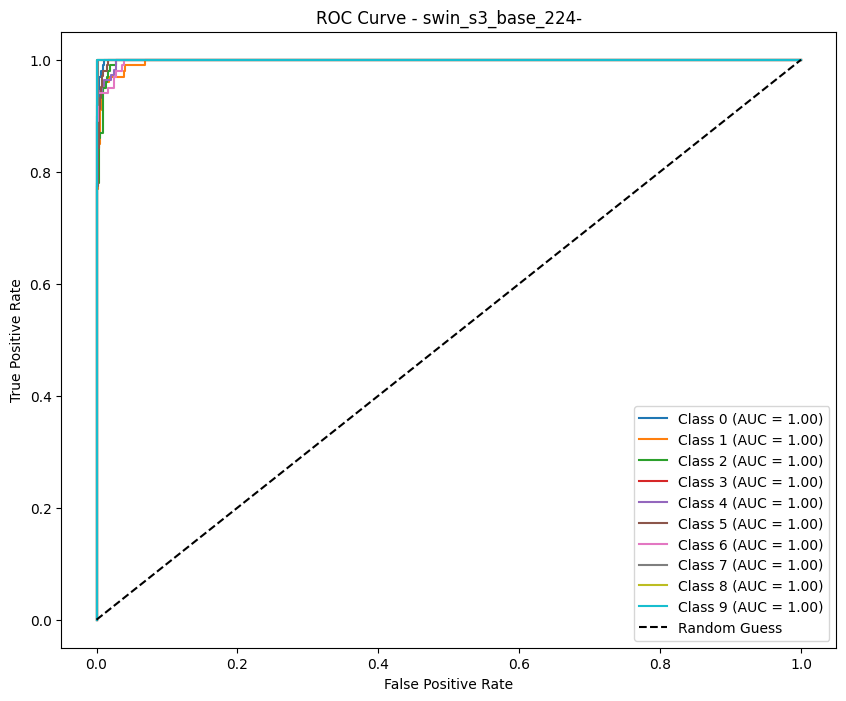

Confusion Matrix:
 [[ 97   1   0   0   0   0   1   1   0   0]
 [  0  96   2   0   0   1   1   0   0   0]
 [  0   2  97   0   1   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  4   0   1   0 103   0   0   0   0   0]
 [  0   0   0   0   0 101   0   0   1   0]
 [  0   1   0   0   1   7  90   0   0   1]
 [  0   0   0   0   0   1   0  99   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.97326902195110032156577517525875
Recall: 0.97338997821350758954395132604986
Precision: 0.97379891281053576612691813352285
Accuracy: 0.97326732673267324358334917633329


In [ ]:
######################## Train model selection: Transformer ########################
lr = 5e-5                                             ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1                                       ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                                           ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0                                          ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1                                      ## default 50
model_name="swin_s3_base_224"                         ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224/swin_s3_base_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False                                      ## True / False, defalt False
opt_name='lookahead_AdamW'                            ## defalt 'lookahead_AdamW', fixed
loss_func="CE"                                        ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

Flops_dic[model_name] = flops
Accuracy_dic[model_name] = accuracy
Params_dic[model_name] = macs
F1_dic[model_name] = f1
Fecall_dic[model_name] = recall
Precision_dic[model_name] = precision


num_classes: 10, len classes:10
/content/vgg16_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/vgg16_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/vgg16_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50.pth exists!!
dict_keys(['eval_loss_epoch', 'accuracy', 'val_loss_metric', 'train_loss_metric', 'train_loss_epoch', 'ema_model_accuracy'])
[tensor(2.1301), tensor(1.8326), tensor(1.6958), tensor(1.5499), tensor(1.4199), tensor(1.2627), tensor(1.1911), tensor(1.0809), tensor(1.0152), tensor(0.9586), tensor(0.8984), tensor(0.8704), tensor(0.8175), tensor(0.7919), tensor(0.7655), tensor(0.7388), tensor(0.6835), tensor(0.6701), tensor(0.6397), tensor(0.6244), tensor(0.6219), tensor(0.6077), tensor(0.5635), tensor(0.5682), tensor(0.5284), tensor(0.5206), tensor(0.5169), tensor(0.4895), tensor(0.4819), tensor(0.4833), tensor(0.4420), tensor(0.4686), tensor(0.4470), tensor(0.4340), tensor(0.4267), tensor(0.4193), tensor(0.4189), tens

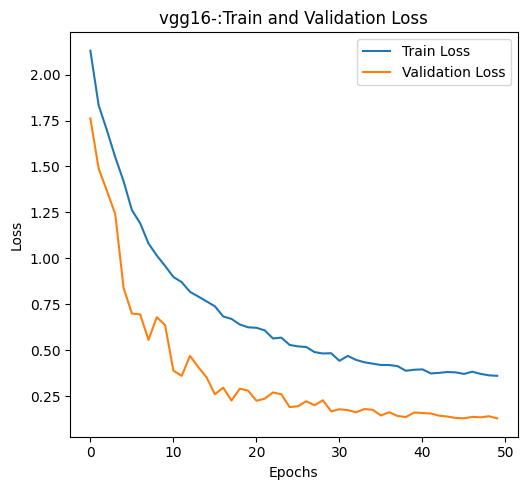

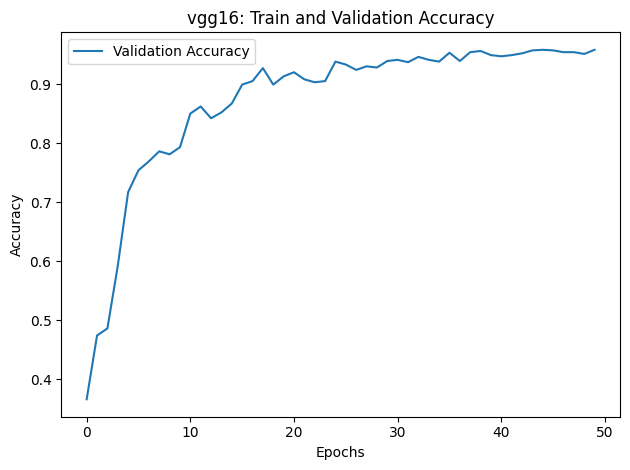

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  134.3 M 
fwd MACs:                                                               15.4662 GMACs
fwd FLOPs:                                                              30.9657 GFLOPS
fwd+bwd MACs:                                                           46.3986 GMACs
fwd+bwd FLOPs:                                                          92.897 GFLOPS

-------------------------------- Detailed Calculated FLOPs

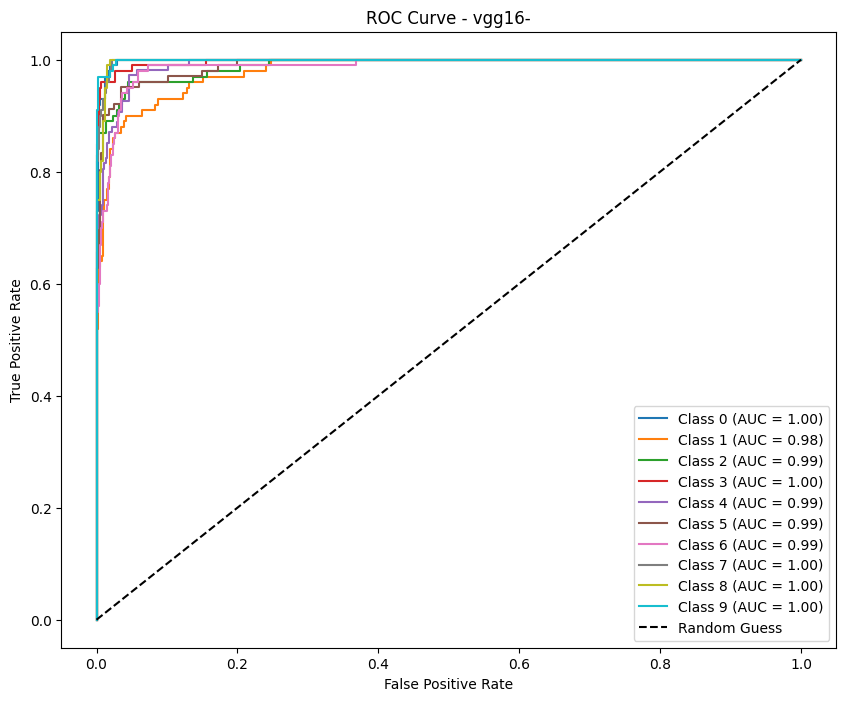

Confusion Matrix:
 [[ 98   0   0   0   1   0   1   0   0   0]
 [  0  94   3   0   1   0   1   0   1   0]
 [  0   5  93   2   0   0   0   0   0   0]
 [  0   0   2  92   3   2   0   0   0   1]
 [  0   0   1   0 107   0   0   0   0   0]
 [  0   0   0   1   1  98   0   0   1   1]
 [  0   1   0   0   4   2  92   0   1   0]
 [  2   0   0   0   0   1   0  97   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   3   0   0   0   0  97]]
F1 Score: 0.95862783912152216281299388356274
Recall: 0.95815250544662311504851004428929
Precision: 0.96003331398328606294256815090193
Accuracy: 0.95841584158415837890743205207400


In [ ]:
######################## Train model selection: vgg16 ########################
lr = 5e-5                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="vgg16"         ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

Flops_dic[model_name] = flops
Accuracy_dic[model_name] = accuracy
Params_dic[model_name] = macs
F1_dic[model_name] = f1
Fecall_dic[model_name] = recall
Precision_dic[model_name] = precision


num_classes: 10, len classes:10
/content/vgg19_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/vgg19_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/vgg19_False_lookahead_AdamW_CE_5e-05_0.1_0.0_0.0_50.pth exists!!
dict_keys(['eval_loss_epoch', 'accuracy', 'val_loss_metric', 'train_loss_metric', 'train_loss_epoch', 'ema_model_accuracy'])
[tensor(2.1448), tensor(1.8742), tensor(1.7551), tensor(1.6387), tensor(1.5230), tensor(1.3837), tensor(1.3025), tensor(1.2056), tensor(1.1164), tensor(1.0649), tensor(0.9923), tensor(0.9495), tensor(0.8999), tensor(0.8898), tensor(0.8462), tensor(0.8098), tensor(0.7662), tensor(0.7220), tensor(0.7109), tensor(0.6760), tensor(0.6777), tensor(0.6666), tensor(0.6237), tensor(0.6147), tensor(0.5891), tensor(0.5757), tensor(0.5619), tensor(0.5449), tensor(0.5193), tensor(0.5134), tensor(0.4791), tensor(0.5108), tensor(0.4845), tensor(0.4685), tensor(0.4526), tensor(0.4508), tensor(0.4470), tens

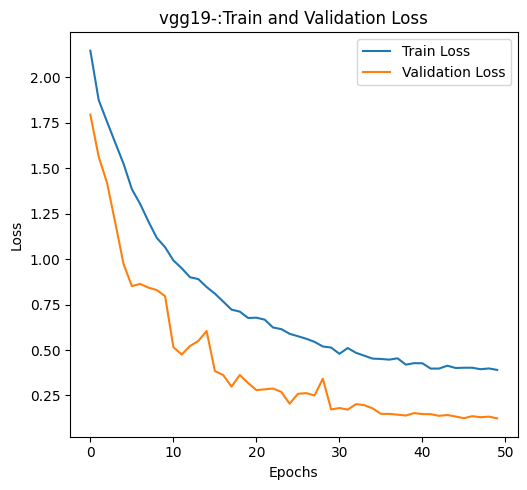

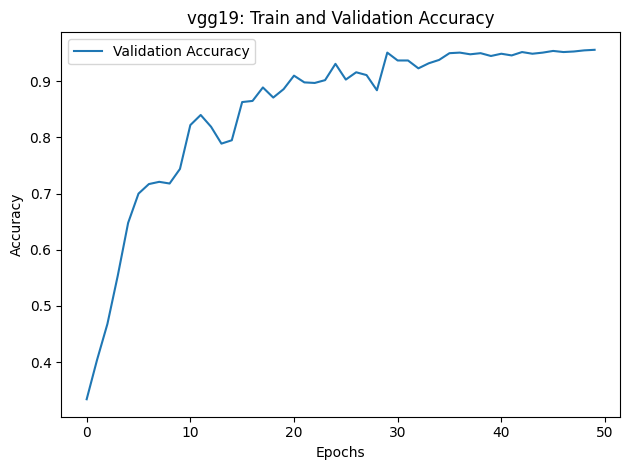

model.safetensors:   0%|          | 0.00/575M [00:00<?, ?B/s]

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  139.61 M
fwd MACs:                                                               19.628 GMACs
fwd FLOPs:                                                              39.2919 GFLOPS
fwd+bwd MACs:                                                           58.884 GMACs
fwd+bwd FLOPs:                                                          117.876 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

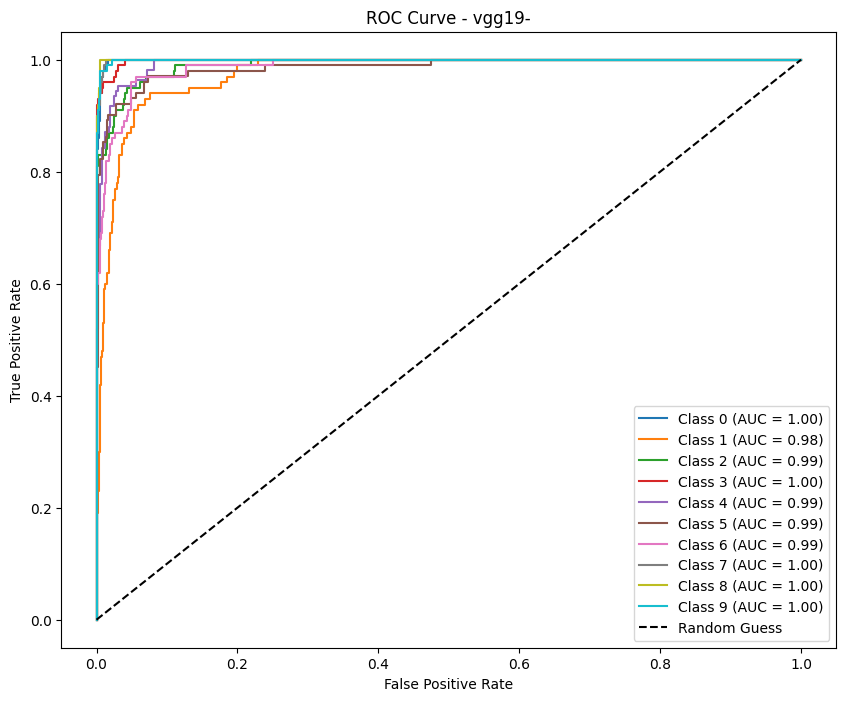

Confusion Matrix:
 [[ 98   0   0   0   0   0   2   0   0   0]
 [  2  88   3   0   1   0   6   0   0   0]
 [  1   3  95   1   0   0   0   0   0   0]
 [  0   0   1  97   2   0   0   0   0   0]
 [  3   0   2   0 103   0   0   0   0   0]
 [  0   0   0   1   1  96   2   0   1   1]
 [  0   0   0   0   4   0  95   0   0   1]
 [  2   0   0   0   0   2   0  96   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   2   0   0   0   0  98]]
F1 Score: 0.95666429604479397141858498798683
Recall: 0.95648801742919398183317980510765
Precision: 0.95779104843000306690470324610942
Accuracy: 0.95643564356435639695064310217276


In [ ]:
######################## Train model selection: vgg19 ########################
lr = 5e-5                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="vgg19"         ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

Flops_dic[model_name] = flops
Accuracy_dic[model_name] = accuracy
Params_dic[model_name] = macs
F1_dic[model_name] = f1
Fecall_dic[model_name] = recall
Precision_dic[model_name] = precision


In [ ]:
# ######################## model selection: DeseNet121 ########################
# lr = 5e-5                           ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
# smoothing = 0.1                     ## 0.1, 0.2, 0.4, default 0.1
# mixup = 0.0                         ## 0.2, 0.4, 0.6, default 0
# cutmix = 0.0                        ## 0.2, 0.4, 0.6, default 0
# num_epochs = 50
# # num_epochs = 1                    ## default 50
# model_name="densenet121"            ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
# pretrained=False                    ## True / False, defalt False
# opt_name='lookahead_AdamW'          ## defalt 'lookahead_AdamW', fixed
# loss_func="CE"                      ## BinaryCrossEntropy, "CE"  default 'CE'

# tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

# output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
# train_val_loss_plot(f'{output_name}_run_history.pkl')

# cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

# Flops_dic[model_name] = flops
# Accuracy_dic[model_name] = accuracy
# Params_dic[model_name] = macs
# F1_dic[model_name] = f1
# Fecall_dic[model_name] = recall
# Precision_dic[model_name] = precision


dict_keys(['resnet50d', 'swin_s3_tiny_224', 'swin_s3_base_224', 'vgg16', 'vgg19'])
dict_values(['8.6901 GFLOPS', '8.7282 GFLOPS', '25.4118 GFLOPS', '30.9657 GFLOPS', '39.2919 GFLOPS'])
dict_keys(['resnet50d', 'swin_s3_tiny_224', 'swin_s3_base_224', 'vgg16', 'vgg19'])
dict_values([0.9158415841584159, 0.9742574257425742, 0.9732673267326732, 0.9584158415841584, 0.9564356435643564])
[30.9657, 39.2919, 8.6901, 25.4118]
[0.9584158415841584, 0.9564356435643564, 0.9158415841584159, 0.9732673267326732]
[15.4662, 19.628, 4.3268, 12.6733]


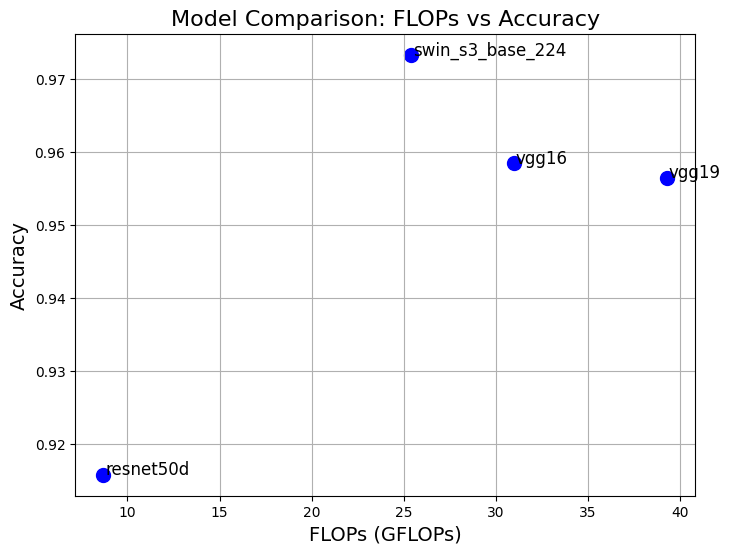

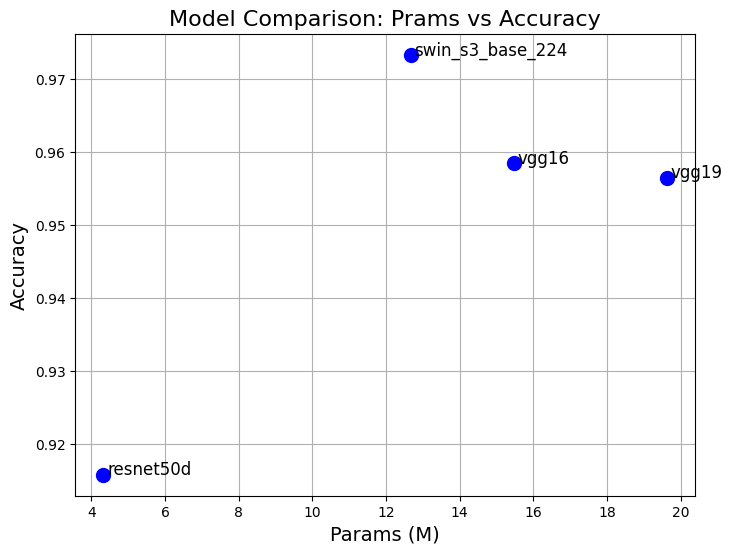

In [ ]:
import matplotlib.pyplot as plt

# model_name_list = ['resnet50d', 'swin_s3_tiny_224', 'swin_s3_base_224', 'vgg16', 'vgg19', 'densenet121']
# Flops_dic = {}
# Accuracy_dic = {}
# Params_dic = {}
# F1_dic = {}
# Fecall_dic = {}
# Precision_dic = {}

# model list
models_list = ['vgg16', 'vgg19', 'resnet50d', 'swin_s3_base_224']
# models = ['vgg16', 'swin_s3_tiny_224', 'resnet50d', 'densenet121', 'swin_s3_base_224']

# FLOP & Accuracy
print(Flops_dic.keys())
print(Flops_dic.values())
print(Accuracy_dic.keys())
print(Accuracy_dic.values())
flops = [float(Flops_dic[model].split()[0]) for model in models_list]
# flops = [Flops_dic[model] for model in models_list]
accuracy = [Accuracy_dic[model] for model in models_list]
params = [float(Params_dic[model].split()[0]) for model in models_list]
# params = [Params_dic[model] for model in models_list]

print(flops)
print(accuracy)
print(params)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(flops, accuracy, color='blue', s=100)
for i, model in enumerate(models_list):
    plt.text(flops[i] + 0.1, accuracy[i], str(model), fontsize=12)

# set up title and lagend
plt.title('Model Comparison: FLOPs vs Accuracy', fontsize=16)
plt.xlabel('FLOPs (GFLOPs)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)

# show
plt.show()

# plot
plt.figure(figsize=(8, 6))
plt.scatter(params, accuracy, color='blue', s=100)
for i, model in enumerate(models_list):
    plt.text(params[i] + 0.1, accuracy[i], str(model), fontsize=12)

# set up title and lagend
plt.title('Model Comparison: Prams vs Accuracy', fontsize=16)
plt.xlabel('Params (M)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)

# show
plt.show()


num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50.pth exists!!
dict_keys(['ema_model_accuracy', 'eval_loss_epoch', 'accuracy', 'train_loss_metric', 'train_loss_epoch', 'val_loss_metric'])
[tensor(1.7433), tensor(1.7960), tensor(1.5829), tensor(1.4157), tensor(1.3032), tensor(1.1616), tensor(1.0867), tensor(0.9754), tensor(0.9115), tensor(0.8415), tensor(0.7860), tensor(0.7450), tensor(0.7133), tensor(0.6823), tensor(0.6577), tensor(0.6302), tensor(0.5919), tensor(0.5646), tensor(0.5376), tensor(0.5258), tensor(0.5150), tensor(0.5021), tensor(0.4633), tensor(0.4510), tensor(0.4272), tensor(0.4252), tensor(0.4075), tensor(0.3883), tensor(0.3691), tensor(0.3605), tensor(0.3253), tensor(0.3392), tensor(0.3147), tensor(0.3110), tensor(0.3036), tensor(0.2726), tensor(0

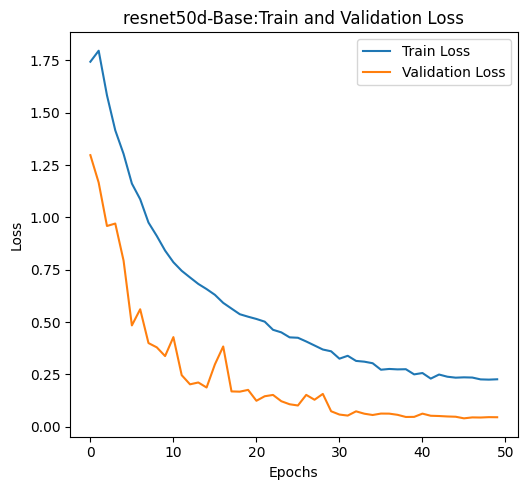

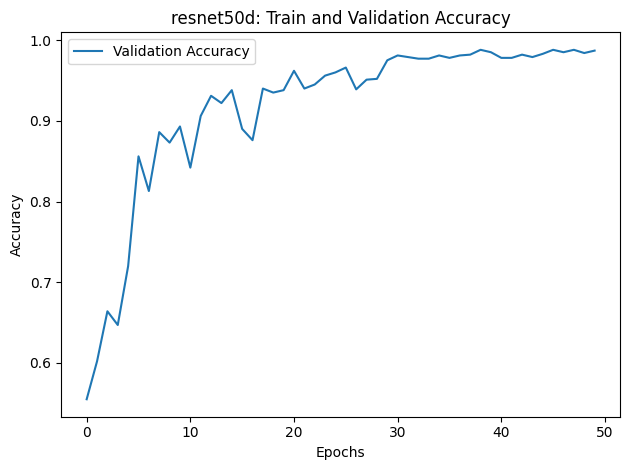

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

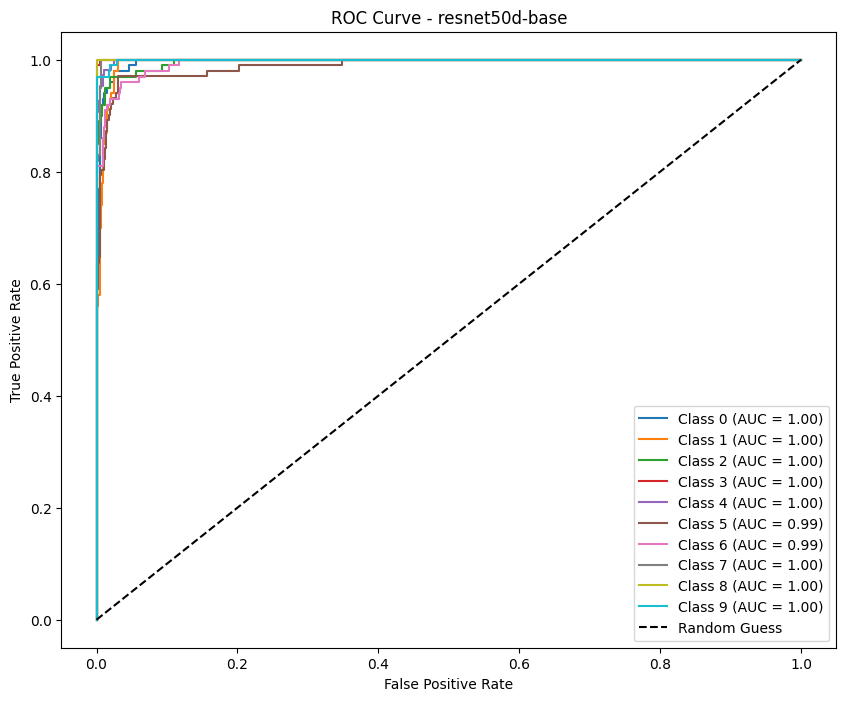

Confusion Matrix:
 [[ 98   0   0   0   0   0   1   1   0   0]
 [  1  99   0   0   0   0   0   0   0   0]
 [  0   1  99   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   0   1   0 100   0   0   1   0]
 [  0   1   0   0   0   1  98   0   0   0]
 [  1   0   0   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   2   0   0   0   1  97]]
F1 Score: 0.98809169464302937235800072812708
Recall: 0.98803921568627450788824262417620
Precision: 0.98825053681838759267463956348365
Accuracy: 0.98811881188118810825926630059257


In [ ]:
# finetune resnet50d
######################## learning rate 5e-3 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', 'Base')

cm, f1, recall, precision, accuracy, flops, macs = eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func, desc="base")


num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_CE_0.5_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.5_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.5_0.1_0.0_0.0_50.pth exists!!
dict_keys(['eval_loss_epoch', 'accuracy', 'val_loss_metric', 'train_loss_metric', 'train_loss_epoch', 'ema_model_accuracy'])
[tensor(2.1849), tensor(2.8637), tensor(2.3333), tensor(2.3571), tensor(2.3332), tensor(2.3315), tensor(3.4316), tensor(2.3278), tensor(2.3246), tensor(2.3227), tensor(2.3270), tensor(2.3296), tensor(2.3241), tensor(2.3254), tensor(2.3257), tensor(2.3244), tensor(2.3232), tensor(2.3207), tensor(2.3221), tensor(2.3229), tensor(2.3192), tensor(2.3200), tensor(3.0059), tensor(2.3159), tensor(2.3174), tensor(2.3156), tensor(2.3147), tensor(2.3142), tensor(2.3133), tensor(2.3140), tensor(2.3114), tensor(2.3114), tensor(2.3102), tensor(2.3112), tensor(2.3092), tensor(2.3077), tensor(2.3076)

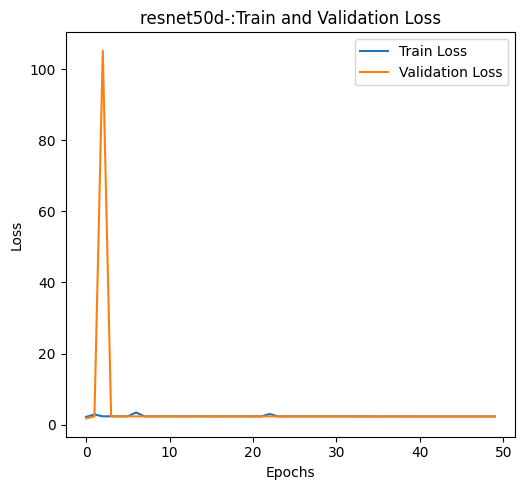

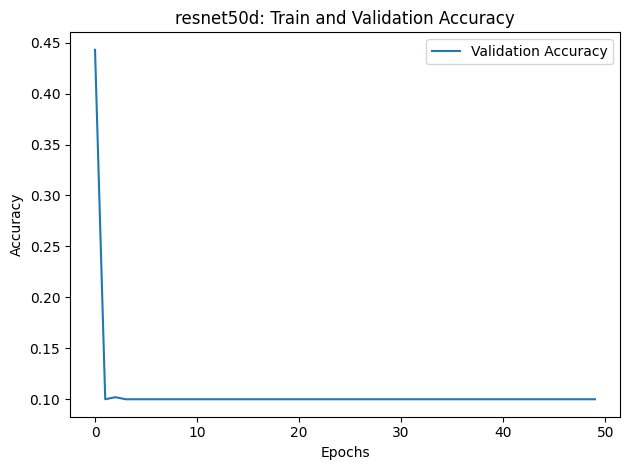

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

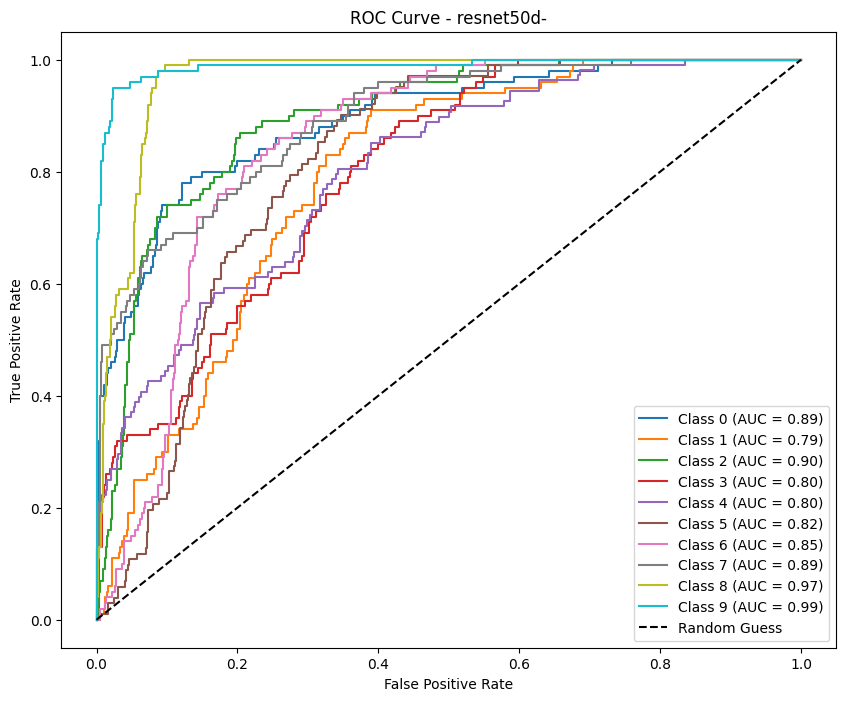

Confusion Matrix:
 [[69  1  6  1  2  5  7  8  1  0]
 [17 26  2  0  0  3 50  0  2  0]
 [ 5  8 23  9  2  4 23  2 23  1]
 [ 3  0  2 29  1 27 23  0 10  5]
 [ 0  1  3  6 20 11 49  4 12  2]
 [ 0  0  6  0  0 12 75  0  6  3]
 [ 1  0  0  0  0  2 92  0  2  3]
 [ 5  1  1  1  0 24  7 55  6  0]
 [ 0  0  0  0  0  0 30  0 53 17]
 [ 1  0  0  0  0  0 31  0  1 67]]
F1 Score: 0.44083548728957266948924598182202
Recall: 0.44428322440087147926490729332727
Precision: 0.56629507280154212089939846919151
Accuracy: 0.44158415841584158778587720917130


(array([[69,  1,  6,  1,  2,  5,  7,  8,  1,  0],
        [17, 26,  2,  0,  0,  3, 50,  0,  2,  0],
        [ 5,  8, 23,  9,  2,  4, 23,  2, 23,  1],
        [ 3,  0,  2, 29,  1, 27, 23,  0, 10,  5],
        [ 0,  1,  3,  6, 20, 11, 49,  4, 12,  2],
        [ 0,  0,  6,  0,  0, 12, 75,  0,  6,  3],
        [ 1,  0,  0,  0,  0,  2, 92,  0,  2,  3],
        [ 5,  1,  1,  1,  0, 24,  7, 55,  6,  0],
        [ 0,  0,  0,  0,  0,  0, 30,  0, 53, 17],
        [ 1,  0,  0,  0,  0,  0, 31,  0,  1, 67]]),
 0.44083548728957267,
 0.4442832244008715,
 0.5662950728015421,
 0.4415841584158416,
 '8.6901 GFLOPS',
 '4.3268 GMACs')

In [ ]:
########################  learning rate 5e-1 ########################
lr = 5e-1                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

num_classes: 10, len classes:10
/content/resnet50d_True_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_True_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_True_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_50.pth exists!!
dict_keys(['ema_model_accuracy', 'train_loss_metric', 'val_loss_metric', 'train_loss_epoch', 'accuracy', 'eval_loss_epoch'])
[tensor(1.3363), tensor(0.7954), tensor(0.5554), tensor(0.4580), tensor(0.3982), tensor(0.3627), tensor(0.3535), tensor(0.3332), tensor(0.3004), tensor(0.2941), tensor(0.2890), tensor(0.2800), tensor(0.2650), tensor(0.2524), tensor(0.2506), tensor(0.2331), tensor(0.2193), tensor(0.2106), tensor(0.2114), tensor(0.1924), tensor(0.1901), tensor(0.1924), tensor(0.1709), tensor(0.1808), tensor(0.1468), tensor(0.1481), tensor(0.1473), tensor(0.1333), tensor(0.1282), tensor(0.1259), tensor(0.1093), tensor(0.1177), tensor(0.0989), tensor(0.0998), tensor(0.0978), tensor(0.0781), tensor(0.08

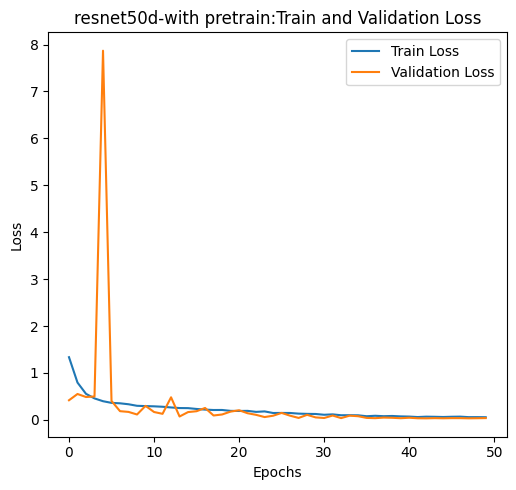

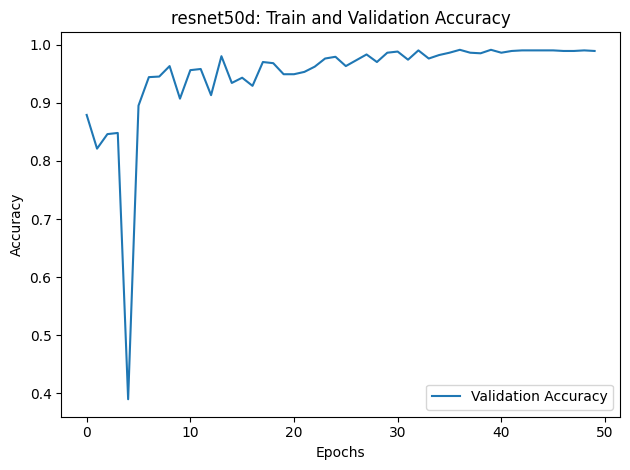

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

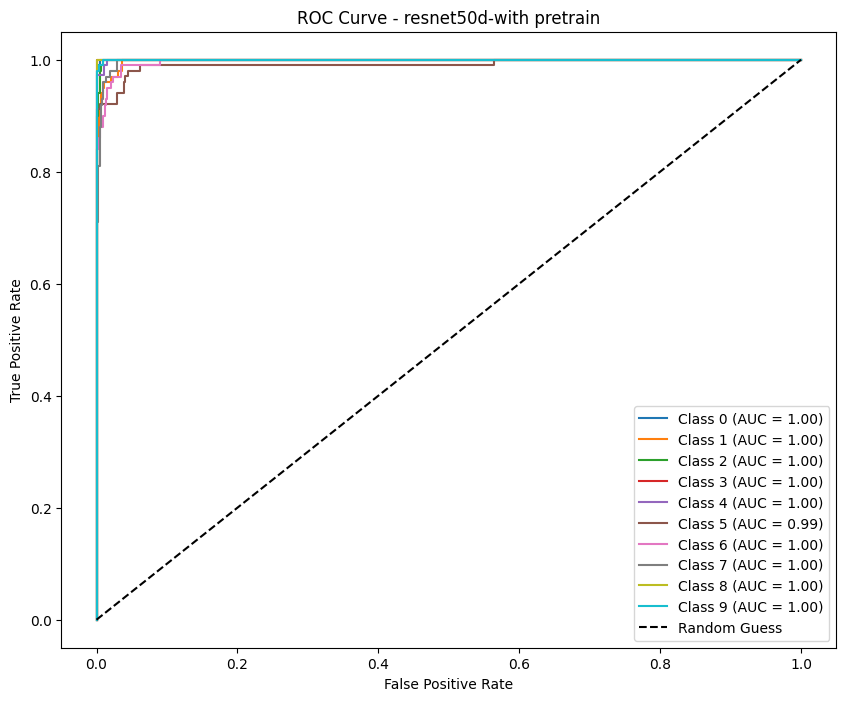

Confusion Matrix:
 [[100   0   0   0   0   0   0   0   0   0]
 [  0  98   2   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   0   1   0 101   0   0   0   0]
 [  1   0   0   0   2   0  97   0   0   0]
 [  1   0   0   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   1   1   0   0   0   0  98]]
F1 Score: 0.99109131746406464724685747569310
Recall: 0.99108910891089108119444972544443
Precision: 0.99128586944545016290675221171114
Accuracy: 0.99108910891089108119444972544443


(array([[100,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,  98,   2,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 100,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0, 108,   0,   0,   0,   0,   0],
        [  0,   0,   0,   1,   0, 101,   0,   0,   0,   0],
        [  1,   0,   0,   0,   2,   0,  97,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,  99,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
        [  0,   0,   0,   1,   1,   0,   0,   0,   0,  98]]),
 0.9910913174640646,
 0.9910891089108911,
 0.9912858694454502,
 0.9910891089108911,
 '8.6901 GFLOPS',
 '4.3268 GMACs')

In [ ]:
######################## pretrain ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', desc_string="with pretrain")

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func, desc="with pretrain")

num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_LSCE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_LSCE_0.005_0.1_0.0_0.0_50_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_LSCE_0.005_0.1_0.0_0.0_50.pth exists!!
dict_keys(['ema_model_accuracy', 'train_loss_metric', 'val_loss_metric', 'train_loss_epoch', 'accuracy', 'eval_loss_epoch'])
[tensor(1.8620), tensor(1.8954), tensor(1.7147), tensor(1.5827), tensor(1.4825), tensor(1.3897), tensor(1.3292), tensor(1.2528), tensor(1.2051), tensor(1.1592), tensor(1.1150), tensor(1.0802), tensor(1.0624), tensor(1.0282), tensor(1.0103), tensor(0.9869), tensor(0.9521), tensor(0.9417), tensor(0.9185), tensor(0.9062), tensor(0.8979), tensor(0.8843), tensor(0.8721), tensor(0.8559), tensor(0.8339), tensor(0.8239), tensor(0.8230), tensor(0.8130), tensor(0.7940), tensor(0.7901), tensor(0.7652), tensor(0.7718), tensor(0.7607), tensor(0.7513), tensor(0.7475), tensor(0.7284), te

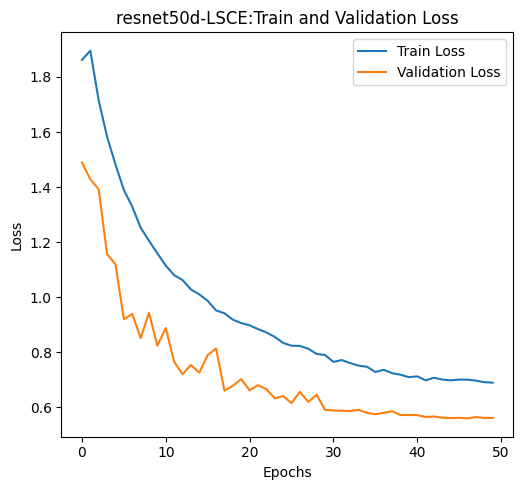

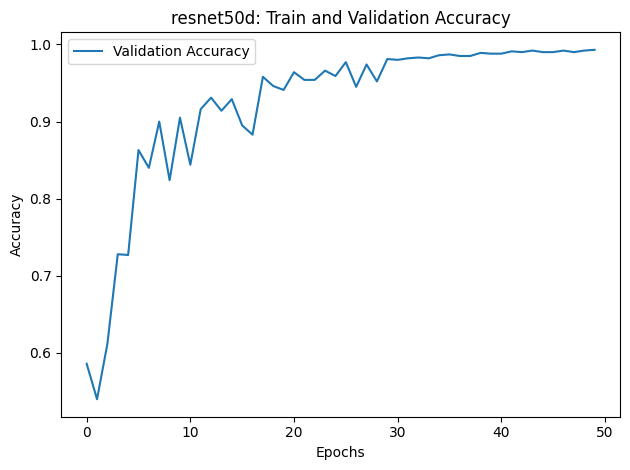

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

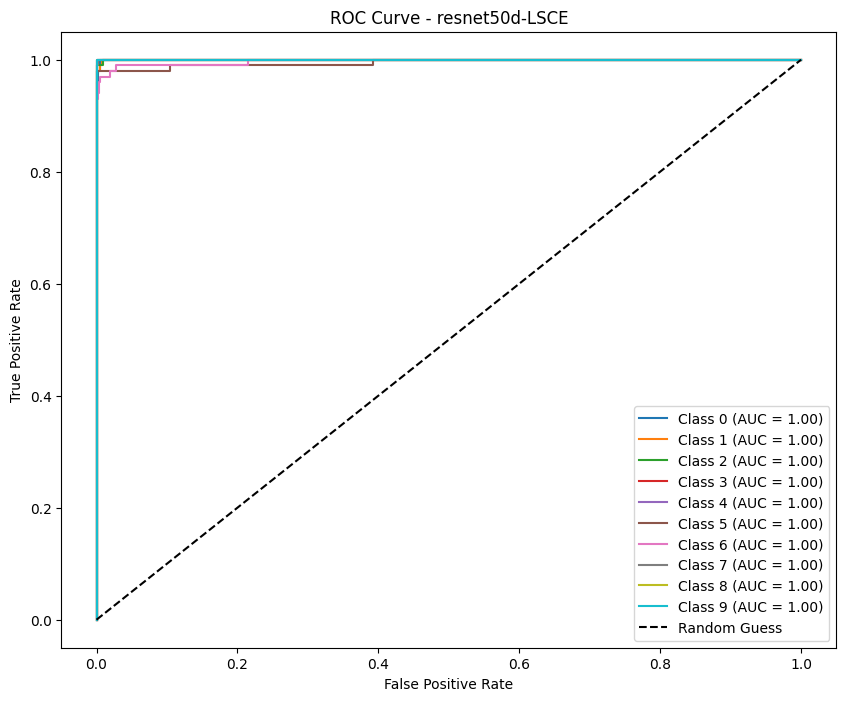

Confusion Matrix:
 [[100   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   1   0   0 100   0   0   1   0]
 [  0   1   0   0   2   0  97   0   0   0]
 [  2   0   0   0   0   0   0  98   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.99307688982440966984910346582183
Recall: 0.99303921568627440130683226016117
Precision: 0.99325073683838982496752123552142
Accuracy: 0.99306930693069306315123867534567


(array([[100,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 100,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0, 108,   0,   0,   0,   0,   0],
        [  0,   0,   1,   0,   0, 100,   0,   0,   1,   0],
        [  0,   1,   0,   0,   2,   0,  97,   0,   0,   0],
        [  2,   0,   0,   0,   0,   0,   0,  98,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100]]),
 0.9930768898244097,
 0.9930392156862744,
 0.9932507368383898,
 0.9930693069306931,
 '8.6901 GFLOPS',
 '4.3268 GMACs')

In [ ]:
######################## loss funciton smooth label ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## CE: BinaryCrossEntropy, LSCE: LabelSmoothingCrossEntropy, default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', desc_string="LSCE")

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func, desc="LSCE")

In [ ]:
# ######################## Train model selection: resnet50d V1 ########################
# lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
# smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
# mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
# cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
# num_epochs = 50
# # num_epochs = 1           ## default 50
# model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
# pretrained=False           ## True / False, defalt False
# opt_name='lookahead_Sgd' ## defalt 'lookahead_AdamW', fixed
# loss_func="CE"           ## CE: BinaryCrossEntropy, LSCE: LabelSmoothingCrossEntropy, default 'CE'


# tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

# output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
# train_val_loss_plot(f'{output_name}_run_history.pkl')

# eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
# ######################## Train model selection: resnet50d V1 ########################
# lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
# smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
# mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
# cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
# num_epochs = 50
# # num_epochs = 1           ## default 50
# model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
# pretrained=False           ## True / False, defalt False
# opt_name='AdamW'           ## defalt 'lookahead_AdamW', fixed
# loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

# tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

# output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
# train_val_loss_plot(f'{output_name}_run_history.pkl')

# eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
#                    pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_70_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_70_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_70.pth exists!!
dict_keys(['ema_model_accuracy', 'train_loss_metric', 'val_loss_metric', 'train_loss_epoch', 'accuracy', 'eval_loss_epoch'])
[tensor(1.7113), tensor(1.7731), tensor(1.5596), tensor(1.3889), tensor(1.2435), tensor(1.1201), tensor(1.0325), tensor(0.9327), tensor(0.8670), tensor(0.8170), tensor(0.7573), tensor(0.7183), tensor(0.6884), tensor(0.6728), tensor(0.6375), tensor(0.6172), tensor(0.5697), tensor(0.5493), tensor(0.5205), tensor(0.5163), tensor(0.4946), tensor(0.4826), tensor(0.4672), tensor(0.4404), tensor(0.4221), tensor(0.4228), tensor(0.4086), tensor(0.3919), tensor(0.3726), tensor(0.3676), tensor(0.3412), tensor(0.3498), tensor(0.3281), tensor(0.3235), tensor(0.3185), tensor(0.2974), tensor(0

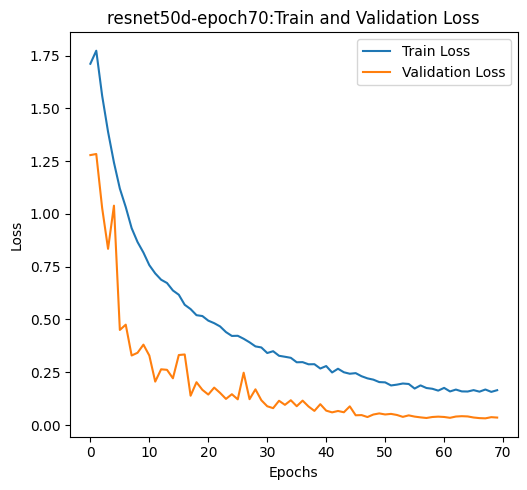

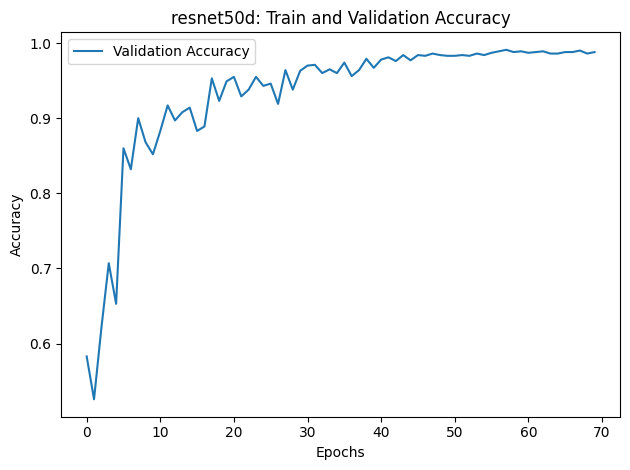

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

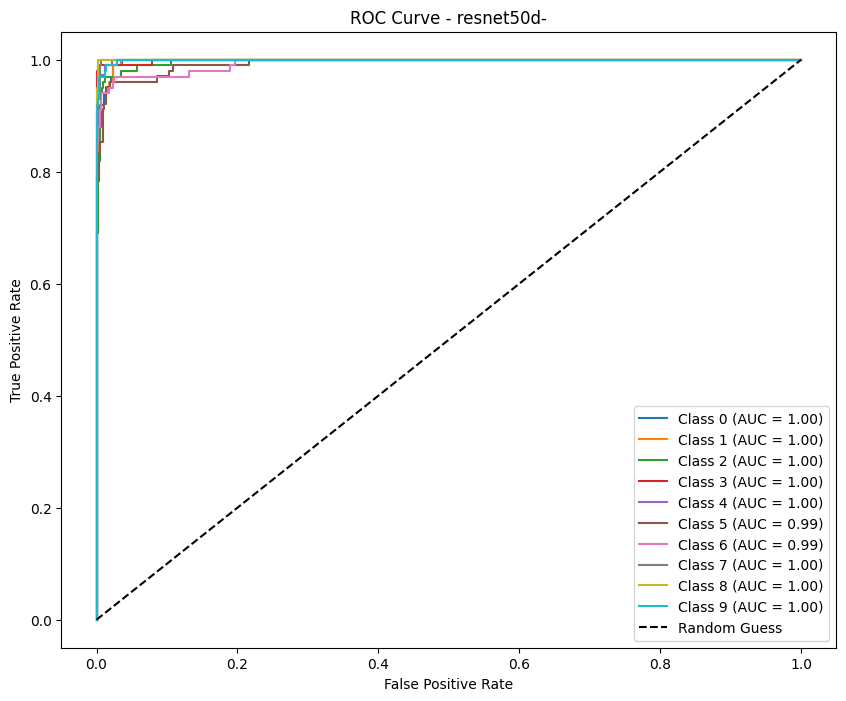

Confusion Matrix:
 [[ 99   0   0   0   0   0   0   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   1  99   0   0   0   0   0   0   0]
 [  0   0   0  99   0   0   0   1   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0   2   0]
 [  0   1   0   0   2   0  97   0   0   0]
 [  1   0   0   0   0   0   0  99   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.99109186669898152732827156796702
Recall: 0.99103921568627451055277788327658
Precision: 0.99128005153456510978315918691806
Accuracy: 0.99108910891089108119444972544443


(array([[ 99,   0,   0,   0,   0,   0,   0,   1,   0,   0],
        [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,  99,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  99,   0,   0,   0,   1,   0,   0],
        [  0,   0,   0,   0, 108,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 100,   0,   0,   2,   0],
        [  0,   1,   0,   0,   2,   0,  97,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,  99,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100]]),
 0.9910918666989815,
 0.9910392156862745,
 0.9912800515345651,
 0.9910891089108911,
 '8.6901 GFLOPS',
 '4.3268 GMACs')

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 70
# num_epochs = 1           ## [50, 70, 90], default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', desc_string="epoch70")

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)



num_classes: 10, len classes:10
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_100_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_100_run_history.pkl exists!!
/content/resnet50d_False_lookahead_AdamW_CE_0.005_0.1_0.0_0.0_100.pth exists!!
dict_keys(['ema_model_accuracy', 'train_loss_metric', 'val_loss_metric', 'train_loss_epoch', 'accuracy', 'eval_loss_epoch'])
[tensor(1.7778), tensor(1.7872), tensor(1.5916), tensor(1.4200), tensor(1.2837), tensor(1.1721), tensor(1.1017), tensor(0.9911), tensor(0.9290), tensor(0.8718), tensor(0.8097), tensor(0.7651), tensor(0.7401), tensor(0.7111), tensor(0.6904), tensor(0.6684), tensor(0.6156), tensor(0.6002), tensor(0.5835), tensor(0.5531), tensor(0.5560), tensor(0.5472), tensor(0.5082), tensor(0.4941), tensor(0.4820), tensor(0.4765), tensor(0.4514), tensor(0.4500), tensor(0.4214), tensor(0.4260), tensor(0.3891), tensor(0.4101), tensor(0.3891), tensor(0.3828), tensor(0.3722), tensor(0.3416), tenso

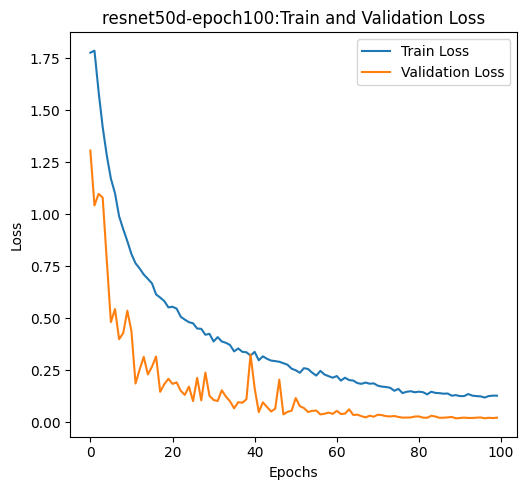

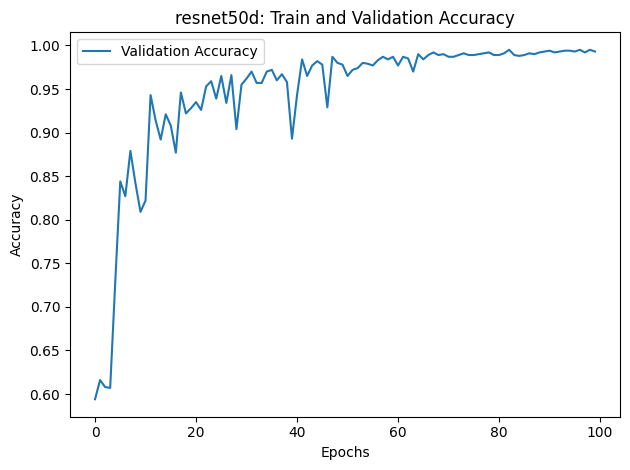

*****************888888888888888*****************

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.55 M 
fwd MACs:                                                               4.3268 GMACs
fwd FLOPs:                                                              8.6901 GFLOPS
fwd+bwd MACs:                                                           12.9804 GMACs
fwd+bwd FLOPs:                                                          26.0704 GFLOPS

-------------------------------- Detailed Calculated FLOPs 

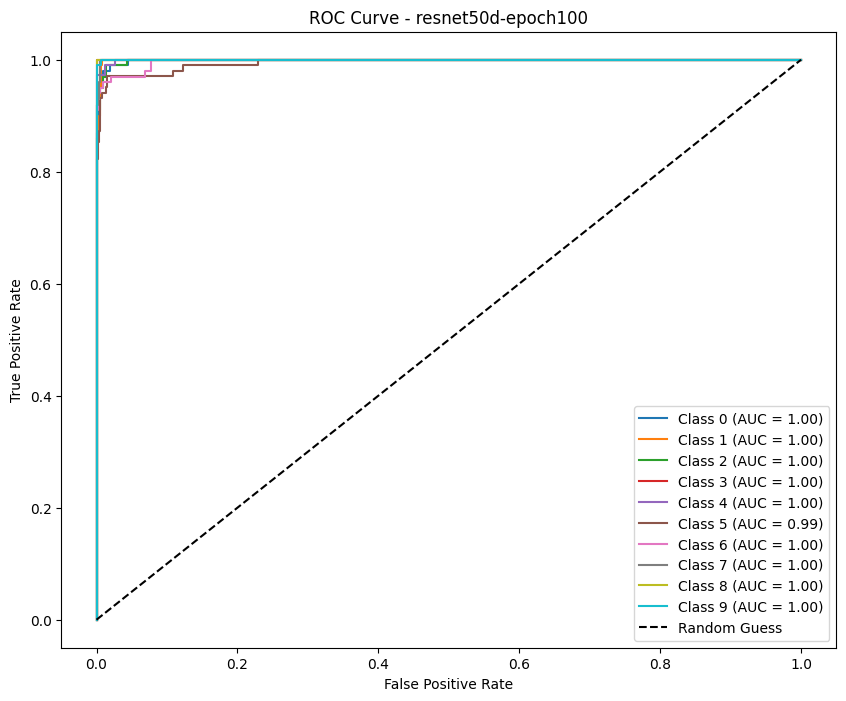

Confusion Matrix:
 [[ 99   0   0   0   0   0   0   1   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 108   0   0   0   0   0]
 [  0   0   0   1   0 100   0   0   1   0]
 [  0   1   0   0   1   0  98   0   0   0]
 [  0   0   0   0   0   0   0 100   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   0   0   0 100]]
F1 Score: 0.99504640817285261444880006820313
Recall: 0.99503921568627462512779402459273
Precision: 0.99512217276773551333235445781611
Accuracy: 0.99504950495049504510802762524690


(array([[ 99,   0,   0,   0,   0,   0,   0,   1,   0,   0],
        [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 100,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0, 108,   0,   0,   0,   0,   0],
        [  0,   0,   0,   1,   0, 100,   0,   0,   1,   0],
        [  0,   1,   0,   0,   1,   0,  98,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 100,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100]]),
 0.9950464081728526,
 0.9950392156862746,
 0.9951221727677355,
 0.995049504950495,
 '8.6901 GFLOPS',
 '4.3268 GMACs')

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 100
# num_epochs = 1           ## [50, 70, 90], default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=False           ## True / False, defalt False
opt_name='lookahead_AdamW' ## defalt 'lookahead_AdamW', fixed
loss_func="CE"             ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', desc_string="epoch100")

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func,desc="epoch100")



In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-5                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl', "epoch=100")

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-4                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 50
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-3                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 100
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

In [ ]:
######################## Train model selection: resnet50d V1 ########################
lr = 5e-4                  ## 5e-1, 5e-3, 5e-5, 5e-7, defult 5e-3
smoothing = 0.1            ## 0.1, 0.2, 0.4, default 0.1
mixup = 0.0                ## 0.2, 0.4, 0.6, default 0
cutmix = 0.0               ## 0.2, 0.4, 0.6, default 0
num_epochs = 100
# num_epochs = 1           ## default 50
model_name="resnet50d"     ## 'Transformer: vit_tiny_patch16_224/swin_s3_tiny_224', 'vgg16/19', 'DenseNet-121:densenet121', default:'resnet50d'
pretrained=True            ## True / False, defalt False
opt_name='lookahead_AdamW'           ## defalt 'lookahead_AdamW', fixed
loss_func="LSCE"           ## BinaryCrossEntropy, "CE"  default 'CE'

tunning_models(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)

output_name = f'{model_name}_{pretrained}_{opt_name}_{loss_func}_{lr}_{smoothing}_{mixup}_{cutmix}_{num_epochs}'
train_val_loss_plot(f'{output_name}_run_history.pkl')

eval_tunned_model(lr, smoothing, mixup, cutmix, num_epochs, model_name=model_name, \
                   pretrained=pretrained, opt_name=opt_name, loss_func=loss_func)